In [1]:
#pip install pandas-datareader
from datetime import datetime
import pandas_datareader.data as wb
import pandas as pd
import math
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
# Machine Learning Library
from fbprophet import Prophet
import lightgbm as lgb

from sklearn.model_selection import train_test_split

C:\Anaconda\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
start = datetime(2018,1,1)
end = datetime(2020,10,30)

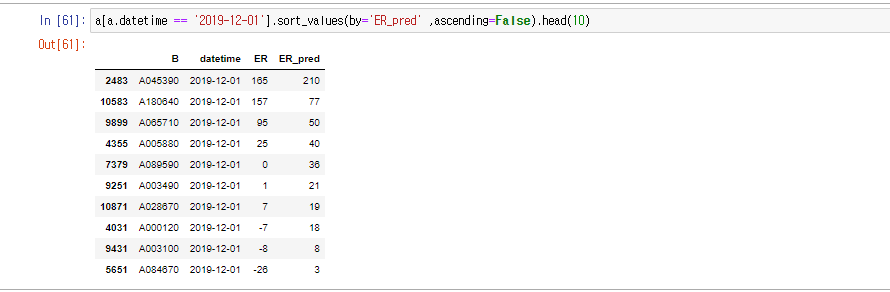

In [3]:
#a1=wb.DataReader('0453990.KS', 'yahoo',start,end)
a1=wb.DataReader('180640.KS', 'yahoo',start,end)
#a2=wb.DataReader('065710.KS', 'yahoo',start,end) 
a2=wb.DataReader('005880.KS', 'yahoo',start,end)
a3=wb.DataReader('089590.KS', 'yahoo',start,end)
a4=wb.DataReader('003490.KS', 'yahoo',start,end)
a5=wb.DataReader('028670.KS', 'yahoo',start,end)
a6=wb.DataReader('000120.KS', 'yahoo',start,end)
#a8=wb.DataReader('003100.KS', 'yahoo',start,end)
a7=wb.DataReader('084670.KS', 'yahoo',start,end)

In [4]:
symbols = ['a1','a2','a3','a4','a5','a6','a7']
data = pd.DataFrame()
data['a1']=a1['Close']
data['a2']=a2['Close']
data['a3']=a3['Close']
data['a4']=a4['Close']
data['a5']=a5['Close']
data['a6']=a6['Close']
data['a7']=a7['Close']
data.columns = symbols
noa = len(symbols)
data.tail()


,a1,a2,a3,a4,a5,a6,a7
Date,,,,,,,
2020-10-26,79100.0,1700.0,13450.0,21400.0,3825.0,163500.0,26350.0
2020-10-27,78700.0,1670.0,13300.0,20750.0,3735.0,160500.0,26200.0
2020-10-28,78800.0,1650.0,13450.0,20800.0,3825.0,161000.0,26200.0
2020-10-29,76900.0,1610.0,13150.0,20300.0,3690.0,159000.0,26200.0
2020-10-30,74700.0,1590.0,12950.0,19950.0,3585.0,159500.0,26150.0


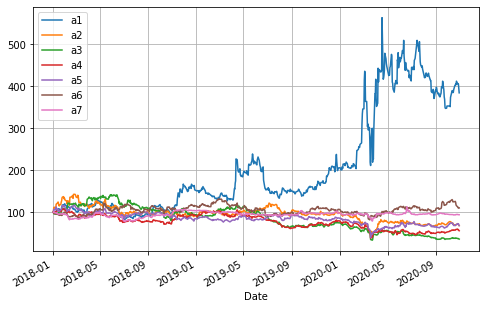

In [5]:
(data / data.iloc[0] * 100).plot(figsize=(8, 5), grid=True)
plt.show()

In [6]:
rets = np.log(data / data.shift(1))
rets.mean() * 252
#252곱하는 이유 = 일간 파라미터로 계산된 값을 연간 파라미터로 변환

a1    0.490028
a2   -0.139939
a3   -0.372328
a4   -0.212423
a5   -0.140301
a6    0.034708
a7   -0.022718
dtype: float64

In [7]:
rets.cov() * 252

,a1,a2,a3,a4,a5,a6,a7
a1,0.541855,0.045864,0.087493,0.131426,0.061361,0.036839,0.009177
a2,0.045864,0.221658,0.073516,0.079659,0.140452,0.045406,0.028584
a3,0.087493,0.073516,0.214688,0.129875,0.086750,0.028497,0.021104
a4,0.131426,0.079659,0.129875,0.179904,0.099641,0.034505,0.021652
a5,0.061361,0.140452,0.086750,0.099641,0.205798,0.047452,0.026562
a6,0.036839,0.045406,0.028497,0.034505,0.047452,0.109880,0.007247
a7,0.009177,0.028584,0.021104,0.021652,0.026562,0.007247,0.046511


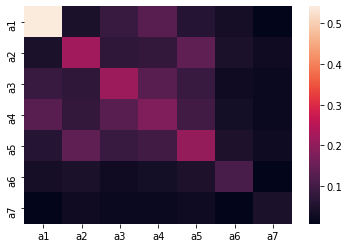

In [8]:
sns.heatmap(rets.cov() * 252)
plt.show()

In [9]:
np.random.seed(2)
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([0.18149384, 0.01079245, 0.22881083, 0.18121389, 0.17498867,
       0.13751018, 0.08519014])

In [10]:
np.sum(rets.mean() * weights) * 252

-0.05797353513043645

In [11]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.09952917562249444

In [12]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.31548244899279965

In [13]:
prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, 
                        np.dot(rets.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

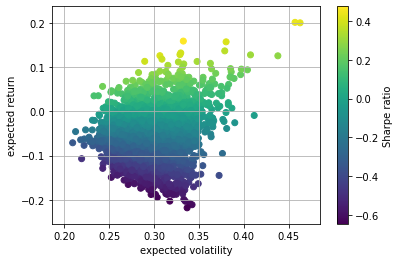

In [14]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

# 샤프지수
샤프지수:  위험 자산에 투자함으로써 얻은 초과 수익의 정도를 나타내는 지표
-> 초과수익률 ÷ 초과수익의 표준편차

초과 수익률=펀드 수익률－무위험 수익률
(무위험 수익률로 보통 국공채 수익률을 이용)

샤프 지수가 1 정도면 그럭저럭 괜찮은 펀드, 2 정도면 쓸만한 펀드 3 이상이면 아주 괜찮은 펀드

다른 펀드와의 비교 목적으로 사용 하는 것이 바람직

->  종합적으로 평가


In [15]:
def statistics(weights):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
        포트폴리오 내의 증권 비중
    
    Returns
    =======
    pret : float
        포트폴리오 수익률의 기댓값
    pvol : float
        포트폴리오 변동성의 기댓값
    pret / pvol : float
        무위험 이자율이 0일 때의 포트폴리오 샤프 지수
    '''
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])


# 샤프지수 최대화

In [16]:
import scipy.optimize as sco

In [17]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [18]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

In [19]:
bnds = tuple((0, 1) for x in range(noa))
bnds

((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1))

In [20]:
noa * [1. / noa,]

[0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285]

In [21]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

Wall time: 51.9 ms


In [22]:
opts

     fun: -0.6657149328742932
     jac: array([-8.04662704e-07,  2.50611924e-01,  6.22125767e-01,  4.56686601e-01,
        2.70429730e-01,  5.35622239e-05,  4.28369194e-02])
 message: 'Optimization terminated successfully.'
    nfev: 45
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([9.85452187e-01, 0.00000000e+00, 2.05564732e-16, 0.00000000e+00,
       1.43385737e-17, 1.45478133e-02, 6.22332047e-17])

In [23]:
opts['x'].round(3)

array([0.985, 0.   , 0.   , 0.   , 0.   , 0.015, 0.   ])

In [24]:
statistics(opts['x']).round(3)

array([0.483, 0.726, 0.666])

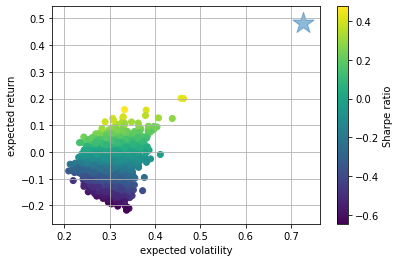

In [25]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5)
plt.show()


# 포트폴리오 분산 최소화

In [26]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

In [27]:
optv = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

In [28]:
optv

     fun: 0.03448618587182409
     jac: array([0.06882828, 0.07141914, 0.06868589, 0.06837891, 0.07211274,
       0.06880551, 0.06906741])
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([2.55360219e-02, 0.00000000e+00, 4.36786689e-02, 1.17362762e-02,
       1.62630326e-18, 2.45066753e-01, 6.73982280e-01])

In [29]:
optv['x'].round(3)

array([0.026, 0.   , 0.044, 0.012, 0.   , 0.245, 0.674])

In [30]:
statistics(optv['x']).round(3)

array([-0.013,  0.186, -0.07 ])

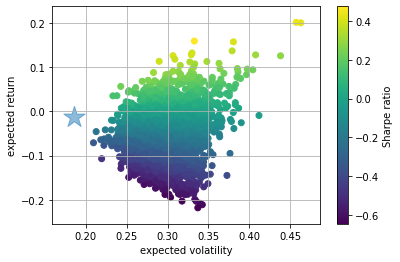

In [31]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

pt_optv = statistics(optv['x']).round(3)
plt.scatter(pt_optv[1], pt_optv[0], marker="*", s=500, alpha=0.5)
plt.show()

# 효율적 투자선

In [32]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [33]:

def min_func_port(weights):
    return statistics(weights)[1]

In [34]:
%%time
trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

Wall time: 4.83 s


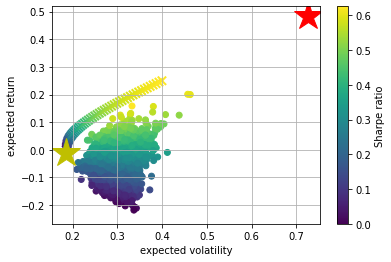

In [35]:
plt.scatter(pvols, prets,
            c=prets / pvols, marker='o')
            # 무작위 포트폴리오
plt.scatter(tvols, trets,
            c=trets / tvols, marker='x', s=70, linewidth=2)
            # 효율적 투자선
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=30)
            # 최대 샤프 지수를 가진 포트폴리오
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize=30)
            # 최소 분산 포트폴리오
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

# 스플라인 함수화

In [36]:
import scipy.interpolate as sci

In [37]:
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

In [38]:
tck = sci.splrep(evols, erets)

In [39]:
def f(x):
    ''' 효율적 투자선 함수 (스플라인 근사) '''
    return sci.splev(x, tck, der=0)

def df(x):
    ''' 효율적 투자선 함수의 1차 도함수 '''
    return sci.splev(x, tck, der=1)

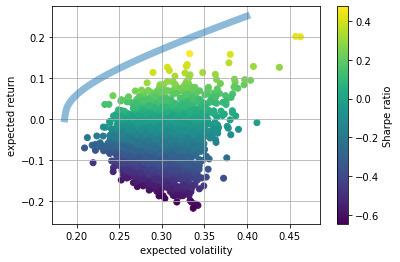

In [40]:
plt.scatter(pvols, prets,
            c=prets / pvols, marker='o')
            # 무작위 포트폴리오

plt.plot(evols, f(evols), lw=7, alpha=0.5)    

plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

# 자본시장선

In [41]:
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

In [42]:
opt = sco.fsolve(equations, [0.01, 1.0, 0.1])
opt

array([0.01      , 0.63460817, 0.59765897])

In [43]:
np.round(equations(opt), 6)

array([ 0.,  0., -0.])

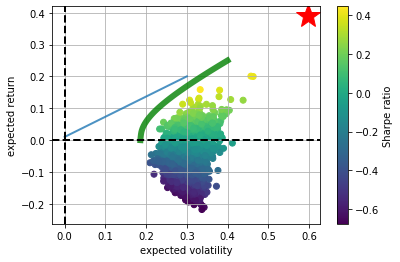

In [44]:
plt.scatter(pvols, prets,
            c=(prets - 0.01) / pvols, marker='o')
            # 무작위 포트폴리오
plt.plot(evols, erets, 'g', lw=6, alpha=0.8)
            # 효율적 투자선
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=2, alpha=0.8)
            # 자본 시장선
plt.plot(opt[2], f(opt[2]), 'r*', markersize=25.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [45]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - f(opt[2])},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
res['x'].round(3)

array([0.779, 0.   , 0.   , 0.   , 0.   , 0.221, 0.   ])

# a1(한진칼)->0.779, a6(CJ대한통운)-> 0.221

